### This version changes the way in which predominant races is determined

### Load up the data and format it

In [2]:
import pandas as pd
from dateutil import parser
from datetime import datetime # for converting and using dates
import pytz
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
articles = pd.read_csv("../../data/processed/gbh_geocoded_output.csv")
demographics = pd.read_csv("../../data/processed/demographics_by_tract.csv")

# Drop unnecessary columns
demographics = demographics.drop(columns=["Index", "Name", "State", "County"])

# Drop rows without neighborhoods
articles.dropna(subset=["Neighborhood"], inplace=True)

# Dictionary to map timezone names to pytz time zones
tzinfos = {'EST': pytz.timezone('US/Eastern'), 'EDT': pytz.timezone('US/Eastern')}

# Function to convert date strings to datetime objects
def convert_to_datetime(date_str):
    return parser.parse(date_str, tzinfos=tzinfos)

# Apply the conversion function to the 'Publication Date' column
articles['Publication Date'] = articles['Publication Date'].apply(convert_to_datetime)

# Ensure the Publication Date column is timezone-aware
articles['Publication Date'] = articles['Publication Date'].dt.tz_convert(pytz.timezone('US/Eastern'))


### Filter on the appropriate month

In [3]:
# Define the date range (example)
start_date = pytz.timezone('US/Eastern').localize(datetime(2023, 3, 1)) # This is the month with most published articles on the given data set
end_date = pytz.timezone('US/Eastern').localize(datetime(2023, 4, 1))

# Filter the DataFrame for the date range
filtered_articles = articles[(articles['Publication Date'] >= start_date) & (articles['Publication Date'] <= end_date)]

print(f"Using articles from {start_date.date()} to {end_date.date()}")

Using articles from 2023-03-01 to 2023-04-01


### Include demographics data

In [4]:
# Function to merge articles with demographics
def merge_articles_with_demographics(articles_df, demographics_df):
    merged_df = pd.merge(articles_df, demographics_df, on='Census Tract', how='left')
    return merged_df

merged_articles = merge_articles_with_demographics(filtered_articles, demographics)

In [5]:
# Define Boston demographics for normalization
boston_demographics = {"White": 0.5985, "African American": 0.2771, "Asian": 0.1195, "American Indian and Alaska Native": 0.003695, "Native Hawaiian and Other Pacific Island": 0.001232, "Other": 0}
boston_demographics_df = pd.DataFrame(list(boston_demographics.items()), columns=['Race', 'Population'])
boston_demographics_df = boston_demographics_df.reset_index(drop=True)
boston_demographics_df["Population"] = round(boston_demographics_df["Population"]*100, 2)


### Label Census Tracts by Predominant Race

Add mixed races as categories to hopefully have a better understanding of data

In [10]:
# Identify predominant race for each census tract
merged_articles['Predominant Race'] = merged_articles[['White', 'African American', 'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Island', 'Other']].idxmax(axis=1)


In [11]:
# Count Census Tracts labeled as each race 
merged_articles["Predominant Race"].value_counts()

Predominant Race
White               91
African American     4
Asian                3
Name: count, dtype: int64

In [12]:
import numpy as np

# Group data by Census Tract and calculate the race distribution
race_distribution_by_tract = merged_articles.groupby('Census Tract')[['White', 'African American', 'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Island', 'Other']].sum()

# Normalize to get percentages
race_distribution_by_tract_percentage = race_distribution_by_tract.div(race_distribution_by_tract.sum(axis=1), axis=0) * 100

# Reset index for easier plotting
race_distribution_by_tract_percentage = race_distribution_by_tract_percentage.reset_index()


In [13]:
# Group data by Census Tract and calculate the race distribution
race_distribution_by_tract = merged_articles.groupby('Census Tract')[['White', 'African American', 'Asian']].sum()

# Normalize to get percentages
race_distribution_by_tract_percentage = race_distribution_by_tract.div(race_distribution_by_tract.sum(axis=1), axis=0) * 100

# Function to determine predominant race based on 70% threshold and combinations
def determine_predominant_race(row):
    # Check if any race meets the 70% threshold
    predominant_race = row[row >= 70].idxmax() if (row >= 70).any() else None

    if predominant_race:
        return predominant_race
    else:
        # Check for combinations
        top_races = row[row >= 20].index.tolist()  # Consider races with at least 20%
        if len(top_races) == 2:
            return f"{top_races[0]} & {top_races[1]}"
        elif len(top_races) == 3:
            return f"{top_races[0]}, {top_races[1]} & {top_races[2]}"
        else:
            return "Mixed/Other"

# Apply the function to each row to determine the predominant race or combination
race_distribution_by_tract_percentage['Predominant Race'] = race_distribution_by_tract_percentage.apply(determine_predominant_race, axis=1)

# Merge the new predominant race information back into the merged_articles DataFrame
predominant_race_mapping = race_distribution_by_tract_percentage['Predominant Race'].to_dict()

# Update the Predominant Race column in merged_articles
merged_articles['Predominant Race'] = merged_articles['Census Tract'].map(predominant_race_mapping)


In [15]:
# Count Census Tracts labeled as each race 
merged_articles["Predominant Race"].value_counts()

Predominant Race
White                       69
White & Asian               21
White & African American     5
African American             2
Mixed/Other                  1
Name: count, dtype: int64

### Calculate the race statistics, boston statistics, and their comparison

In [16]:
# Function to get article and topic counts, and topic distribution for a given race
def get_race_stats(df, race):
    race_df = df[df['Predominant Race'] == race]
    topic_distribution = race_df['Closest Topic'].value_counts()
    article_count = len(race_df)
    total_articles = len(df)
    topic_count = len(topic_distribution)
    percent_articles = article_count / total_articles * 100
    topic_percent = topic_distribution / total_articles* 100
    
    return {
        "Topic Distribution": topic_distribution,
        "Topic Count": topic_count,
        "Article Count": article_count,
        "Percent of Total Articles": percent_articles,
        "Topic Percent": topic_percent
    }

# Overall Boston statistics
def get_boston_stats(df):
    topic_distribution = df["Closest Topic"].value_counts()
    article_count = len(df)
    topic_count = len(topic_distribution)
    
    return {
        "Topic Distribution": topic_distribution,
        "Topic Count": topic_count,
        "Article Count": article_count
    }

# Compare race stats to Boston stats
def compare_race_to_boston(race_stats, boston_stats):
    comparison = {
        "Race Article %": race_stats["Percent of Total Articles"],
        "Race Topic %": race_stats["Topic Percent"],
        "Boston Topic %": (boston_stats["Topic Distribution"] / boston_stats["Article Count"] * 100)
    }
    
    return comparison

# Get relevant census tracts and neighborhoods for a given race
def get_relevant_census_tracts(df, race):
    census_tracts = df[df["Predominant Race"] == race]["Census Tract"].value_counts()
    neighborhoods = df[df["Predominant Race"] == race]["Neighborhood"].value_counts()
    
    return {
        "Census Tracts": census_tracts,
        "Neighborhoods": neighborhoods
    }

### Run an example

In [17]:
# Get Boston stats
boston_stats = get_boston_stats(merged_articles)

# Example race analysis
race = "White"  # Check with relevant race
race_stats = get_race_stats(merged_articles, race)

# Compare race stats to Boston stats
comparison = compare_race_to_boston(race_stats, boston_stats)

# Get relevant census tracts and neighborhoods for the given race
relevant_stats = get_relevant_census_tracts(merged_articles, race)

# Display relevant census tracts and neighborhoods
print(f"Top Predominantly {race} Census Tracts:\n", relevant_stats["Census Tracts"].head())
print(f"\nTop Predominantly {race} Neighborhoods:\n", relevant_stats["Neighborhoods"].head())
print(f"\nTopic count for {race} Race: {race_stats["Topic Count"]} \n")
print(f"Top 5 topics:  {race_stats["Topic Distribution"].head(5)} \n")
print(f"Article count: {race_stats["Article Count"]} \n")  


Top Predominantly White Census Tracts:
 Census Tract
30302     36
20302     11
10600      6
981700     3
60501      2
Name: count, dtype: int64

Top Predominantly White Neighborhoods:
 Neighborhood
Downtown        40
Beacon Hill     11
Back Bay         7
South Boston     2
Fenway           2
Name: count, dtype: int64

Topic count for White Race: 28 

Top 5 topics:  Closest Topic
Local Politics          11
Politics/Elections       9
Other                    8
Housing/Homelessness     6
Taxes                    3
Name: count, dtype: int64 

Article count: 69 



{'White': 70.40816326530613, 'White & Asian': 21.428571428571427, 'White & African AmericanAfrican American': 0.0, 'Mixed/Other': 1.0204081632653061, 'Asian': 0.0, 'White, African American & Asian': 0.0}


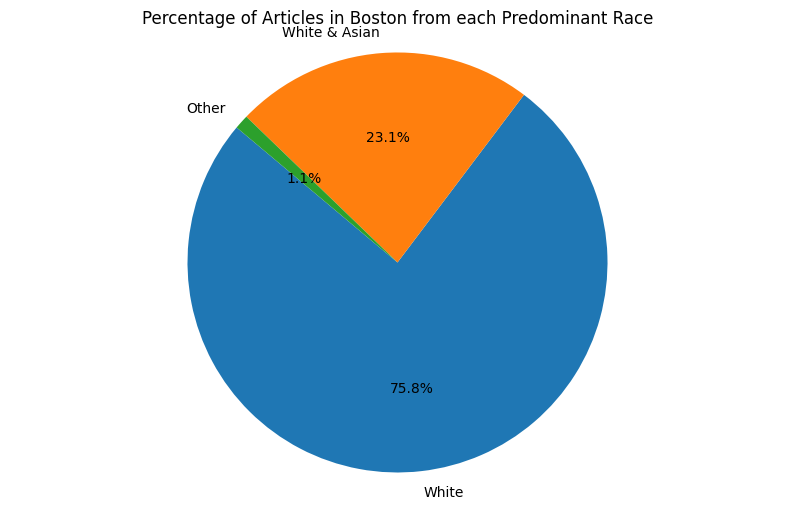

In [31]:
# Visualize the percentage of articles in Boston that come from census tracts with each predominant race
# List of main races
races = ['White', 'White & Asian', "White & African American" 'African American', "Mixed/Other", "Asian", "White, African American & Asian"]

# Calculate the percentage of articles for each race
race_article_percentages = {}
total_articles = len(merged_articles)

for race_ in races:
    race_article_count = len(merged_articles[merged_articles['Predominant Race'] == race_])
    race_article_percentages[race_] = (race_article_count / total_articles) * 100

print(race_article_percentages)

# Sort the percentages in descending order and select the top 3
sorted_race_article_percentages = dict(sorted(race_article_percentages.items(), key=lambda item: item[1], reverse=True))
top_3_races = dict(list(sorted_race_article_percentages.items())[:2])

# Combine the rest into an "Other" category
other_percentage = sum(list(sorted_race_article_percentages.values())[2:])
top_3_races['Other'] = other_percentage

# Prepare data for the pie chart
labels = list(top_3_races.keys())
sizes = list(top_3_races.values())

# Plot the pie chart
plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Percentage of Articles in Boston from each Predominant Race")
plt.axis('equal')
plt.show()

C:\Users\axel0\AppData\Local\Temp\ipykernel_26244\3108354406.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=race_stats["Topic Distribution"].values, y=race_stats["Topic Distribution"].index, palette="viridis")


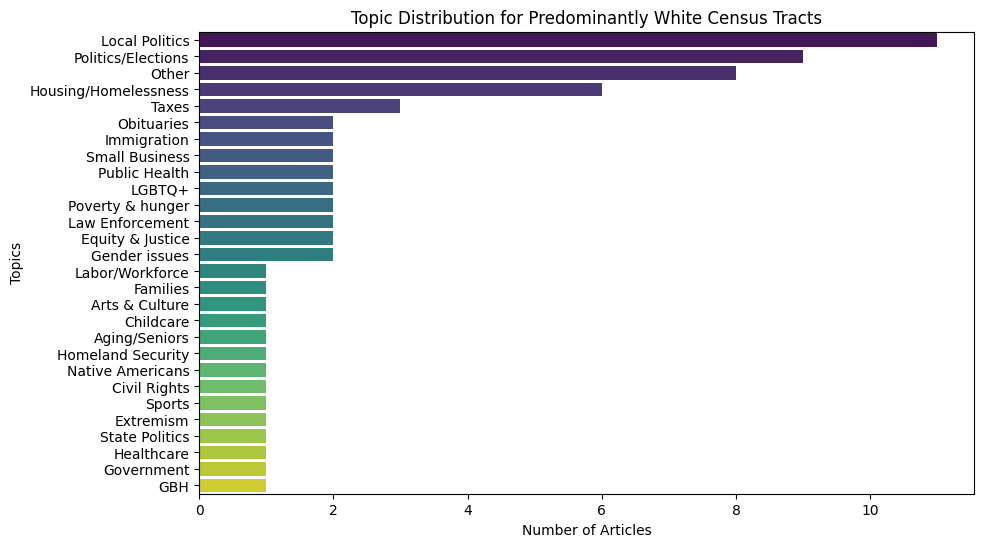

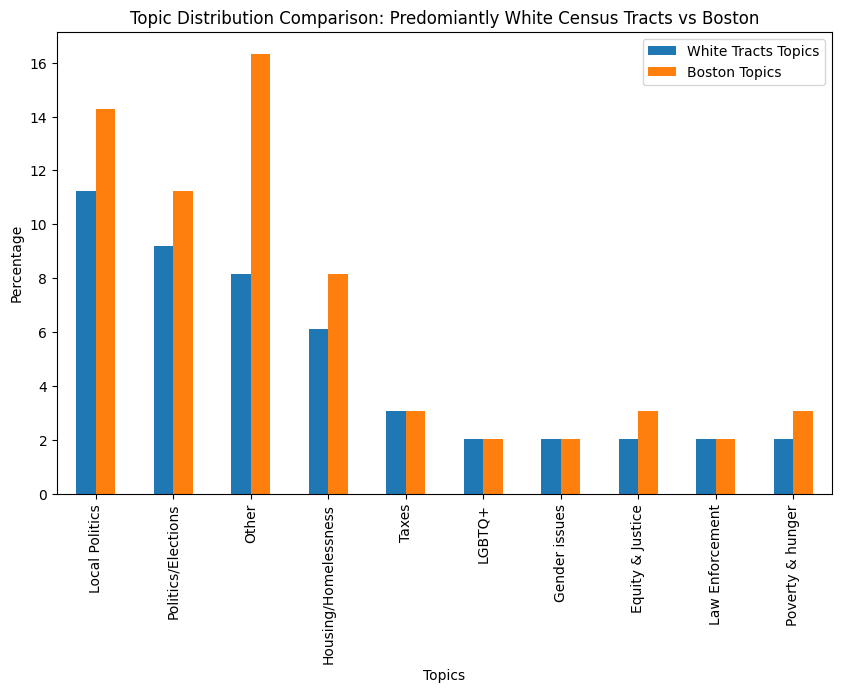

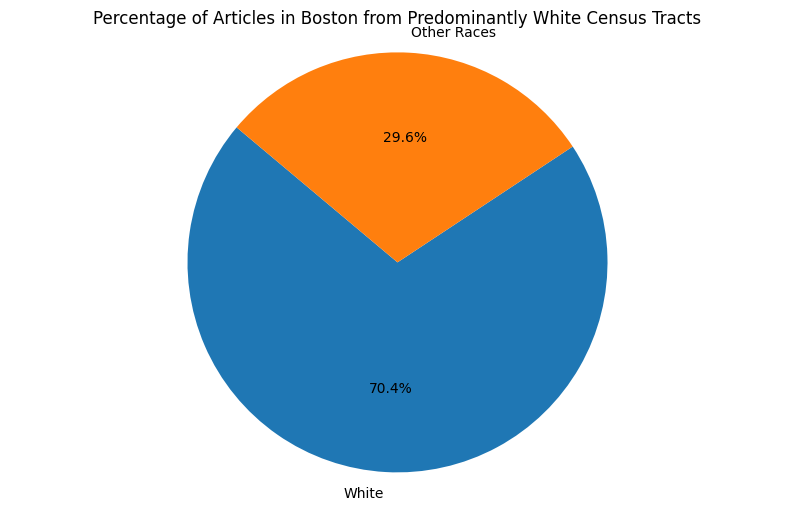

In [21]:
# Visualize topic distribution for the given race
plt.figure(figsize=(10, 6))
sns.barplot(x=race_stats["Topic Distribution"].values, y=race_stats["Topic Distribution"].index, palette="viridis")
plt.xlabel("Number of Articles")
plt.ylabel("Topics")
plt.title(f"Topic Distribution for Predominantly {race} Census Tracts")
plt.show()

# Visualize comparison of topic distribution
top_race_topics = comparison["Race Topic %"].sort_values(ascending=False).head(10)
boston_topics_filtered = comparison["Boston Topic %"].reindex(top_race_topics.index)

comparison_df = pd.DataFrame({
    f"{race} Tracts Topics": top_race_topics,
    "Boston Topics": boston_topics_filtered
})

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.xlabel("Topics")
plt.ylabel("Percentage")
plt.title(f"Topic Distribution Comparison: Predomiantly {race} Census Tracts vs Boston")
plt.show()



# Visualize the percentage of articles in Boston that come from census tracts with the predominant race
race_article_percentage = race_stats["Percent of Total Articles"]
plt.figure(figsize=(10, 6))
plt.pie([race_article_percentage, 100 - race_article_percentage], labels=[race, "Other Races"], autopct='%1.1f%%', startangle=140)
plt.title(f"Percentage of Articles in Boston from Predominantly {race} Census Tracts")
plt.axis('equal') 
plt.show()